In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray
import glob
import matplotlib.colors as colors
from matplotlib import cm
import palettable

### Eddy Flux Tower Data

In [3]:
path = '/jet/home/xjliu/work/DATA/Flux_Tower/'
data2 = pd.read_csv(path+'Control-Tha-Results.csv')
data = data2.sort_values(by='Datetime')
data = data.rename(columns={'m':'Month'})

data2 = pd.read_csv(path+'Soy-Tha-Results.csv')
data_crop = data2.sort_values(by='Datetime')
data_crop = data_crop.rename(columns={'m':'Month'})


/ocean/projects/atm200007p/xjliu/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (174,306,314) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### WRF output Data

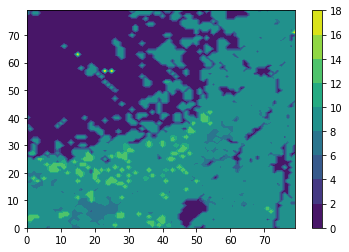

In [7]:
### OBS land use
path = '/jet/home/xjliu/Tanguro_exp/Tanguro201401/'
file = path+'wrfout_d01_2014-01-01_00:00:00'
with xarray.open_dataset(file,decode_times=True,
                         mask_and_scale='True') as ds:
    LU_Index = ds['LU_INDEX'][0,:,:] # change it to local time
    lons = ds['XLONG'][0,:,:]
    lats = ds['XLAT'][0,:,:]
plt.contourf(LU_Index)
plt.colorbar()

In [36]:
### OBS land use
path = '/jet/home/xjliu/Tanguro_exp/post_processing/LH/'
file = path+'LH_Tanguro_dry_ensmean_obs.nc'
with xarray.open_dataset(file,decode_times=True,
                         mask_and_scale='True') as ds:
    LH_JJA = ds['LH'][:,:,:] # change it to local time
LH_JJA_forest_areamean = LH_JJA[:,40:,0:30].mean(('south_north','west_east'))
LH_JJA_savannah_areamean = LH_JJA[:,0:20,55:70].mean(('south_north','west_east'))

file = path+'LH_Tanguro_wet_ensmean_obs.nc'
with xarray.open_dataset(file,decode_times=True,
                         mask_and_scale='True') as ds1:
    LH_JFM = ds1['LH'][:,:,:] # change it to local time
LH_JFM_forest_areamean = LH_JFM[:,40:,0:30].mean(('south_north','west_east'))
LH_JFM_savannah_areamean = LH_JFM[:,0:20,55:70].mean(('south_north','west_east'))

month_sel = [[12,1,2],[6,7,8]]
forest_JJA = data[(data.Month.isin(month_sel[1]))]# & (data.Year.isin(np.arange(2014,2016)))]
crop_JJA = data_crop[(data_crop.Month.isin(month_sel[1]))]# & (data_crop.Year.isin(np.arange(2014,2016)))]
forest_mn_JJA,forest_CI_JJA = bootstrap_ci(forest_JJA,'LE','Hour')
crop_mn_JJA,crop_CI_JJA = bootstrap_ci(crop_JJA,'LE','Hour')

forest_JFM = data[(data.Month.isin(month_sel[0]))]# & (data.Year.isin(np.arange(2014,2016)))]
crop_JFM = data_crop[(data_crop.Month.isin(month_sel[0]))]# & (data_crop.Year.isin(np.arange(2014,2016)))]
forest_mn_JFM,forest_CI_JFM = bootstrap_ci(forest_JFM,'LE','Hour')
crop_mn_JFM,crop_CI_JFM = bootstrap_ci(crop_JFM,'LE','Hour')

### Bootstraping method to estimate the mean of LE

In [4]:
def bootstrap_ci(df, variable, classes, repetitions = 1000, alpha = 0.05, random_state=None): 
    
    df = df[[variable,classes]]
    bootstrap_sample_size = len(df) 
    class_size = len(df[classes].unique())
    sample_mean = np.empty([class_size,1])
   
    for i in range(repetitions):
            bootstrap_sample = df.sample(n = bootstrap_sample_size, replace = True, random_state = random_state)
            avg = bootstrap_sample.groupby(classes).mean()
            sample_mean = np.hstack((sample_mean,avg))
            
    # confidence interval
    bounds = pd.DataFrame(index=np.arange(class_size),columns=['left','right'])
    right = np.empty([class_size,1])
    left = np.empty([class_size,1])

    for ii in range(class_size):
        left[ii] = np.percentile(sample_mean[ii,:], alpha/2*100)
        right[ii] = np.percentile(sample_mean[ii,:], 100-alpha/2*100)
    # point estimate
        point_est = df.groupby(classes).mean()
        #point_est = sample_mean.mean(1)
    bounds.left = left
    bounds.right = right
    #print('Point estimate of difference between means:', round(point_est,2))
    #print(round(bounds.left,2))
    #print((1-alpha)*100,'%','confidence interval for the difference between means:', (round(left,2), round(right,2)))

    return (point_est,bounds)


### Mean LE of all available years

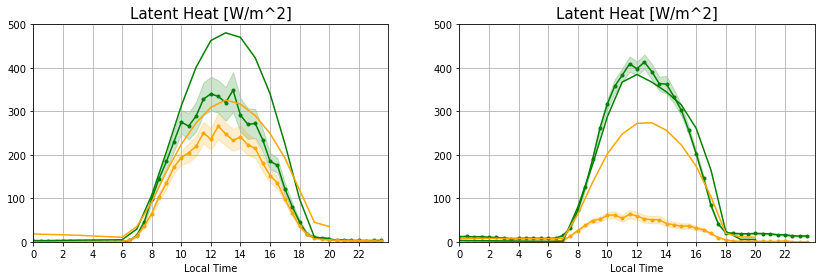

In [49]:
month_sel = [[12,1,2],[6,7,8]]
colors=['g','g']

labels=['(a) Wet Season (DJF)','(b) Dry Season (JJA)']
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True)
axes = axes.ravel()
for ii in range(2):
    forest = data[(data.Month.isin(month_sel[ii]))]# & (data.Year.isin(np.arange(2014,2016)))]
    crop = data_crop[(data_crop.Month.isin(month_sel[ii]))]# & (data_crop.Year.isin(np.arange(2014,2016)))]

    forest_mn,forest_CI = bootstrap_ci(forest,'LE','Hour')
    crop_mn,crop_CI = bootstrap_ci(crop,'LE','Hour')

    axes[ii].plot(np.arange(0,24,0.5),forest_mn,'-',color=colors[ii],
                 label='Forest')
    axes[ii].plot(np.arange(0,24,0.5),forest_mn,'.',color=colors[ii],
                 label='Forest')
    axes[ii].fill_between(np.arange(0,24,0.5),forest_CI.left,forest_CI.right,
                 color=colors[ii],alpha=0.2)
    
    axes[ii].plot(np.arange(0,24,0.5),crop_mn,'-',color='orange',
                 label='Soybean')
    axes[ii].plot(np.arange(0,24,0.5),crop_mn,'.',color='orange',
                 label='Soybean')
    axes[ii].fill_between(np.arange(0,24,0.5),crop_CI.left,crop_CI.right,
                 color='orange',alpha=0.2)
    
    axes[ii].set_xticks(np.arange(0,24,2))
   # axes[ii].set_xticklabels(np.arange(0,24,2))
    axes[ii].set_xlabel('Local Time')
    axes[ii].set_ylim([0,500])
    axes[ii].set_xlim([0,24])
    axes[ii].set_title('Latent Heat [W/m^2]',fontsize=15)
    axes[ii].grid()
    #axes[ii].text(-0.5,730,labels[ii],fontsize=14)

axes[1].plot(LH_JJA_forest_areamean[3:],'g',label='WRF Data; forest')
axes[1].plot(LH_JJA_savannah_areamean[3:],'orange',label='WRF Data; Savannah')
axes[0].plot(LH_JFM_forest_areamean[3:],'g')
axes[0].plot(LH_JFM_savannah_areamean[3:],'orange')


### LE of each year

Text(0, 0.5, 'Other months')

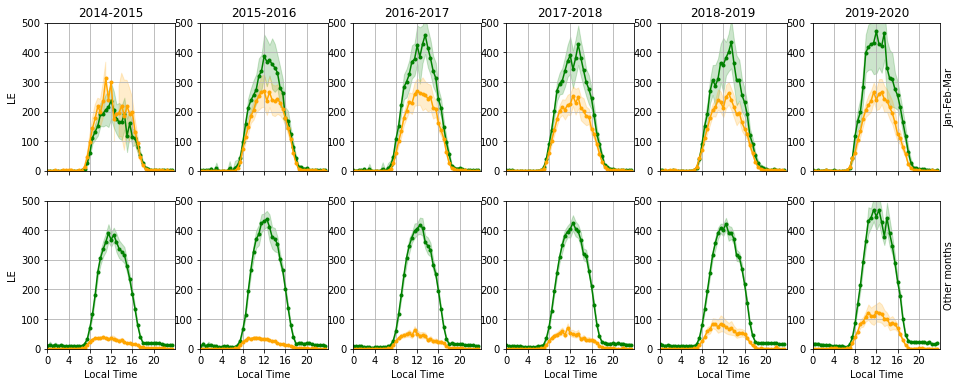

In [5]:
fig,axes = plt.subplots(2,6,figsize=(16,6),sharex=True)
#axes = axes.ravel()

for season in range(2):
    for ii, year in enumerate(np.arange(2014,2020)):
        #print(ii)
        forest = data[(data.Month.isin(month_sel[season]))& (data.Year.isin([year,year+1]))]
        crop = data_crop[(data_crop.Month.isin(month_sel[season])) & (data_crop.Year.isin([year,year+1]))]

        forest_mn,forest_CI = bootstrap_ci(forest,'LE','Hour')
        crop_mn,crop_CI = bootstrap_ci(crop,'LE','Hour')

        axes[season,ii].plot(np.arange(48),forest_mn,'-',color='green',
                     label='Forest')
        axes[season,ii].plot(np.arange(48),forest_mn,'.',color='green',
                     label='Forest')
        axes[season,ii].fill_between(np.arange(48),forest_CI.left,forest_CI.right,
                     color='green',alpha=0.2)

        axes[season,ii].plot(np.arange(48),crop_mn,'-',color='orange',
                     label='Soybean')
        axes[season,ii].plot(np.arange(48),crop_mn,'.',color='orange',
                     label='Soybean')
        axes[season,ii].fill_between(np.arange(48),crop_CI.left,crop_CI.right,
                     color='orange',alpha=0.2)

        axes[season,ii].set_xticks(np.arange(0,48,8))
        axes[season,ii].set_xticklabels(np.arange(0,24,4))
        axes[1,ii].set_xlabel('Local Time')
        axes[season,ii].set_ylim([0,500])
        axes[season,ii].set_xlim([0,48])
        axes[0,ii].set_title(str(year)+'-'+str(year+1),fontsize=12)
        axes[season,ii].grid()
        #axes[ii].text(-0.5,730,labels[ii],fontsize=14)
    
    axes[season,0].set_ylabel('LE')
    axes[season,5].yaxis.set_label_position("right")

axes[0,5].set_ylabel('Jan-Feb-Mar')
axes[1,5].set_ylabel('Other months')

#fig.savefig('plot_Tanguro_LE.png',format='png')

## Overlay WRF data

In [61]:
### OBS land use
path = '/jet/home/xjliu/Tanguro_exp/post_processing/LH/'
file = path+'LH_Tanguro_dry_ensmean_obs.nc'
with xarray.open_dataset(file,decode_times=True,
                         mask_and_scale='True') as ds:
    LH_JJA = ds['LH'][:,:,:] # change it to local time
LH_JJA_forest_areamean = LH_JJA[:,40:,0:30].mean(('south_north','west_east'))
LH_JJA_savannah_areamean = LH_JJA[:,0:20,55:70].mean(('south_north','west_east'))

file = path+'LH_Tanguro_wet_ensmean_obs.nc'
with xarray.open_dataset(file,decode_times=True,
                         mask_and_scale='True') as ds1:
    LH_JFM = ds1['LH'][:,:,:] # change it to local time
LH_JFM_forest_areamean = LH_JFM[:,40:,0:30].mean(('south_north','west_east'))
LH_JFM_savannah_areamean = LH_JFM[:,0:20,55:70].mean(('south_north','west_east'))

month_sel = [[12,1,2],[6,7,8]]
forest_JJA = data[(data.Month.isin(month_sel[1]))]# & (data.Year.isin(np.arange(2014,2016)))]
crop_JJA = data_crop[(data_crop.Month.isin(month_sel[1]))]# & (data_crop.Year.isin(np.arange(2014,2016)))]
forest_mn_JJA,forest_CI_JJA = bootstrap_ci(forest_JJA,'LE','Hour')
crop_mn_JJA,crop_CI_JJA = bootstrap_ci(crop_JJA,'LE','Hour')

forest_JFM = data[(data.Month.isin(month_sel[0]))]# & (data.Year.isin(np.arange(2014,2016)))]
crop_JFM = data_crop[(data_crop.Month.isin(month_sel[0]))]# & (data_crop.Year.isin(np.arange(2014,2016)))]
forest_mn_JFM,forest_CI_JFM = bootstrap_ci(forest_JFM,'LE','Hour')
crop_mn_JFM,crop_CI_JFM = bootstrap_ci(crop_JFM,'LE','Hour')

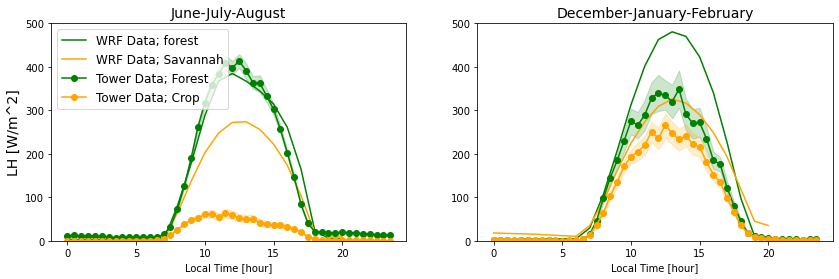

In [62]:
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True)
axes = axes.ravel()
axes[0].plot(LH_JJA_forest_areamean[3:],'g',label='WRF Data; forest')
axes[0].plot(LH_JJA_savannah_areamean[3:],'orange',label='WRF Data; Savannah')
axes[0].plot(forest_mn_JJA,'-go',label='Tower Data; Forest')
axes[0].plot(crop_mn_JJA,'-o',color='orange',label='Tower Data; Crop')
axes[0].fill_between(np.arange(0,24,0.5),forest_CI_JJA.left,forest_CI_JJA.right,
                 color='green',alpha=0.2)
axes[0].fill_between(np.arange(0,24,0.5),crop_CI_JJA.left,crop_CI_JJA.right,
                 color='orange',alpha=0.2)

axes[1].plot(LH_JFM_forest_areamean[3:],'g')
axes[1].plot(LH_JFM_savannah_areamean[3:],'orange')
axes[1].plot(forest_mn_JFM,'-go')
axes[1].plot(crop_mn_JFM,'-o',color='orange')
axes[1].fill_between(np.arange(0,24,0.5),forest_CI_JFM.left,forest_CI_JFM.right,
                 color='green',alpha=0.2)
axes[1].fill_between(np.arange(0,24,0.5),crop_CI_JFM.left,crop_CI_JFM.right,
                 color='orange',alpha=0.2)

axes[0].set_title('June-July-August',fontsize=14)
axes[1].set_title('December-January-February',fontsize=14)
axes[0].set_xlabel('Local Time [hour]')
axes[1].set_xlabel('Local Time [hour]')
axes[0].set_ylabel('LH [W/m^2]',fontsize=14)
axes[0].legend(fontsize=12)
axes[0].set_ylim([0,500])
axes[1].set_ylim([0,500])

fig.savefig('plot_FluxTower_WRF.png',format='png',dpi=600,bbox_inches='tight')

# STOP HERE

In [ ]:
month_sel = [[1,2,3],[6,7,8]]
fields = ['LEv','Hv']
colors=['g','red']
labels=['(a) Wet Season (DJF)','(b) Dry Season (JJA)']
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True)
axes = axes.ravel()
for ii in range(2):
    mean = data[data.Month.isin(month_sel[ii])].groupby('Hour').mean()
    std = data[data.Month.isin(month_sel[ii])].groupby('Hour').std()
    axes[ii].plot(np.arange(mean.shape[0]),mean.LEv,'-',color=colors[ii],
                 label='Tower over forest')
    axes[ii].fill_between(np.arange(mean.shape[0]),mean.LEv-2*std.LEv,mean.LEv+2*std.LEv,
                 color=colors[ii],alpha=0.2)
    axes[ii].set_xticks(np.arange(0,48,4))
    axes[ii].set_xticklabels(np.arange(0,24,2))
    axes[ii].set_xlabel('Local Time')
    axes[ii].set_ylim([-100,800])
    axes[ii].set_xlim([-2,48])
    axes[ii].set_title('Latent Heat [W/m^2]',fontsize=15)
    axes[ii].text(-0.5,730,labels[ii],fontsize=14)
    
## Overlay the WRF output
axes[0].plot(np.arange(0,48,2),LH_forest_DJF,'k',
            label='WRF output')
axes[1].plot(np.arange(0,48,2),LH_forest_JJA,'k',
            label='WRF output')
axes[0].legend()

In [ ]:
### For Savanah
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True)
axes = axes.ravel()
for ii in range(2):
    mean = data_crop[data_crop.Month.isin(month_sel[ii])].groupby('Hour').mean()
    std = data_crop[data_crop.Month.isin(month_sel[ii])].groupby('Hour').std()
    axes[ii].plot(np.arange(mean.shape[0]),mean.LEv,'-',color=colors[ii],
                 label='Tower over Cropland')
    axes[ii].fill_between(np.arange(mean.shape[0]),mean.LEv-2*std.LEv,mean.LEv+2*std.LEv,
                 color=colors[ii],alpha=0.2)
    axes[ii].set_xticks(np.arange(0,48,4))
    axes[ii].set_xticklabels(np.arange(0,24,2))
    axes[ii].set_xlabel('Local Time')
    axes[ii].set_ylim([-100,800])
    axes[ii].set_xlim([-2,48])
    axes[ii].set_title('Latent Heat [W/m^2]',fontsize=15)
    axes[ii].text(-0.5,730,labels[ii],fontsize=14)
    
## Overlay the WRF output
axes[0].plot(np.arange(0,48,2),LH_savanah_DJF,'k',
            label='WRF output')
axes[1].plot(np.arange(0,48,2),LH_savanah_JJA,'k',
            label='WRF output')
axes[0].legend()

## Put the wet and dry season LH together for both Savanah and Forests.

In [ ]:
month_sel = [[12,1,2],[6,7,8]]
colors=['g','red']
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True)
axes = axes.ravel()
axes[0].plot(np.arange(0,48,2),LH_forest_DJF,'k',color='g',
            label='Forest')
axes[0].plot(np.arange(0,48,2),LH_savanah_DJF,'k',color='r',
            label='Savanah')
axes[0].legend()

axes[1].plot(np.arange(0,48,2),LH_forest_JJA,'k',color='g',
            label='Forest')
axes[1].plot(np.arange(0,48,2),LH_savanah_JJA,'k',color='r',
            label='Savanah')
axes[1].legend()

for ii in range(2):
    axes[ii].set_xlim([-2,48])
    axes[ii].set_ylim([0,550])
    axes[ii].set_xticks(np.arange(0,48,4))
    axes[ii].set_xticklabels(np.arange(0,24,2))
    axes[ii].set_xlabel('Local Time')
    axes[ii].set_ylabel('Latent Heat [W/m^2]', fontsize=14)
axes[0].set_title('(a) Wet Season',fontsize=16)
axes[1].set_title('(b) Dry Season',fontsize=16)